In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-future-crop-challenge/pr_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_train.parquet
/kaggle/input/the-future-crop-challenge/sample_submission.csv
/kaggle/input/the-future-crop-challenge/soil_co2_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_train.parquet
/kaggle/input/the-future-crop-challenge/tasmin_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_test.parquet
/kaggle/input/the-future-crop-challenge/soil_co2_maize_test.parquet
/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_test.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_test.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_test.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_train.parquet
/kaggle/input/the-fu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
import kagglehub
kagglehub.login()

In [4]:
the_future_crop_challenge_path = kagglehub.competition_download('the-future-crop-challenge')
print("data import successfully")

data import successfully


In [7]:
def load_data(crop: str, mode: str="train"):
    base_path = the_future_crop_challenge_path

    tasmax = pd.read_parquet(f"{base_path}/tasmax_{crop}_{mode}.parquet")
    tasmin = pd.read_parquet(f"{base_path}/tasmin_{crop}_{mode}.parquet")
    pr = pd.read_parquet(f"{base_path}/pr_{crop}_{mode}.parquet")
    rsds = pd.read_parquet(f"{base_path}/rsds_{crop}_{mode}.parquet")
    soil_co2 = pd.read_parquet(f"{base_path}/soil_co2_{crop}_{mode}.parquet")

    target = None
    if mode == "train":
        target = pd.read_parquet(f"{base_path}/train_solutions_{crop}.parquet")

    return {
        'tasmax': tasmax,
        'tasmin': tasmin,
        'pr': pr,
        'rsds': rsds,
        'soil_co2': soil_co2,
        'target': target,
    }

In [8]:
# Load training data for maize
maize_train = load_data("maize", "train")

In [9]:
def aggregate_daily_data(df):
    numeric_df = df.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')
    return numeric_df.agg(['mean', 'max', 'min', 'std'], axis=1)
tasmax_agg_maize = aggregate_daily_data(maize_train['tasmax'])
tasmin_agg_maize = aggregate_daily_data(maize_train['tasmin'])
pr_agg_maize = aggregate_daily_data(maize_train['pr'])
rsds_agg_maize = aggregate_daily_data(maize_train['rsds'])
tasmax_agg_maize.columns = [f'tasmax_{col}' for col in tasmax_agg_maize.columns]
tasmin_agg_maize.columns = [f'tasmin_{col}' for col in tasmin_agg_maize.columns]
pr_agg_maize.columns = [f'pr_{col}' for col in pr_agg_maize.columns]
rsds_agg_maize.columns = [f'rsds_{col}' for col in rsds_agg_maize.columns]

feature_maize = pd.concat([tasmax_agg_maize, tasmin_agg_maize, pr_agg_maize, rsds_agg_maize, maize_train['soil_co2']], axis = 1)
target_maize = maize_train['target']

In [31]:
feature_maize

,tasmax_mean,tasmax_max,tasmax_min,tasmax_std,tasmin_mean,tasmin_max,tasmin_min,tasmin_std,pr_mean,pr_max,...,rsds_min,rsds_std,crop,year,lon,lat,texture_class,real_year,co2,nitrogen
ID,,,,,,,,,,,,,,,,,,,,,
0,17.839436,29.090820,4.201721,5.273438,8.632730,14.806366,-3.116882,3.260431,0.000043,0.000457,...,5.591039,90.259311,maize,381.0,-122.25,48.25,9.0,1982,340.79,186.110992
1,16.734991,27.898071,2.099579,5.440257,7.719133,14.462341,-5.306366,3.538944,0.000048,0.000629,...,5.754406,89.745583,maize,381.0,-122.25,48.75,9.0,1982,340.79,186.110992
2,16.004420,28.686737,0.422302,6.039337,7.395196,15.773743,-8.419312,4.045676,0.000083,0.000977,...,3.781173,89.038533,maize,381.0,-122.25,49.25,9.0,1982,340.79,184.934006
3,20.881835,36.500885,-0.738281,9.764356,5.692856,17.426544,-12.058136,6.111002,0.000016,0.000162,...,26.691336,101.988291,maize,381.0,-116.75,43.25,9.0,1982,340.79,186.110992
4,22.615727,37.733215,-0.096375,9.605713,7.982770,19.343414,-10.309570,5.960675,0.000015,0.000203,...,19.430513,103.514785,maize,381.0,-116.75,43.75,10.0,1982,340.79,186.110992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349714,18.528323,33.398590,-7.685638,10.676819,8.551638,22.149750,-16.150940,10.141844,0.000024,0.000343,...,17.483034,75.899524,maize,419.0,132.75,46.75,9.0,2020,414.89,221.811996
349715,18.352557,33.134186,-8.825165,10.733707,8.365118,22.621735,-16.659058,10.170843,0.000024,0.000392,...,28.723750,75.370455,maize,419.0,132.75,47.25,9.0,2020,414.89,221.811996
349716,19.024050,32.286957,-8.187988,9.448358,9.654589,23.300964,-15.566376,9.549049,0.000028,0.000425,...,33.978424,72.468355,maize,419.0,133.25,45.25,9.0,2020,414.89,1.846000


In [11]:
# Drop non-numeric columns
numeric_features_maize = feature_maize.select_dtypes(include=[np.number])

# Scale features
scaler_maize = StandardScaler()
features_scaled_maize = scaler_maize.fit_transform(numeric_features_maize)

In [12]:
year_series = maize_train['tasmax']['year']

In [13]:
# Step 2: Find validation year (2020)
val_year = year_series.max()  # Should be 2020
print(f"Using year {val_year} for validation.")

Using year 419.0 for validation.


In [14]:
val_mask = (year_series == val_year)

# Step 4: Split data
X_train = features_scaled_maize[~val_mask]
X_val = features_scaled_maize[val_mask]
y_train = target_maize[~val_mask].values.ravel()
y_val = target_maize[val_mask].values.ravel()

In [15]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [16]:
y_val_pred = rf_model.predict(X_val)

# Step 7: Evaluation
from sklearn.metrics import mean_squared_error, r2_score

rmse = mean_squared_error(y_val, y_val_pred, squared=False)
r2 = r2_score(y_val, y_val_pred)

print(f"Random Forest Validation RMSE (2020): {rmse:.4f}")
print(f"Random Forest Validation R2 (2020): {r2:.4f}")

Random Forest Validation RMSE (2020): 0.9421
Random Forest Validation R2 (2020): 0.8536


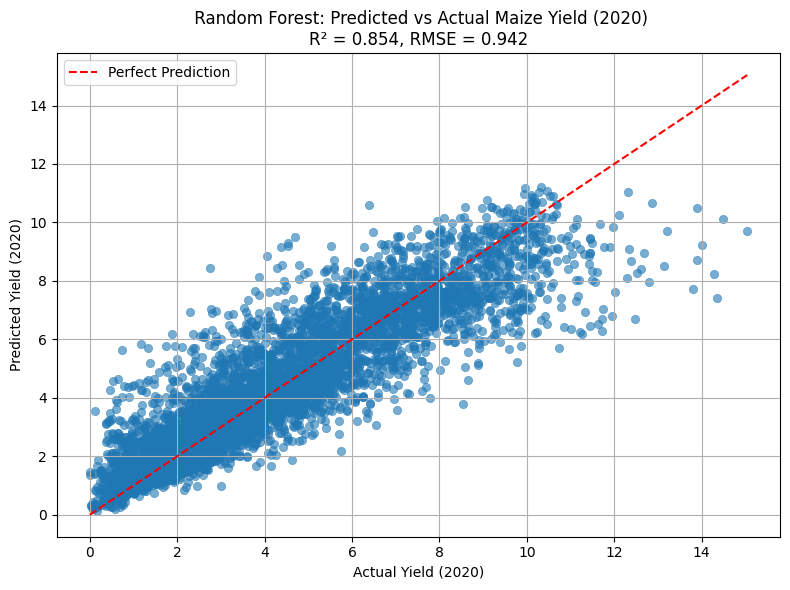

In [17]:
# Predicted vs Actual Scatter Plot (for 2020)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.6, edgecolor=None)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield (2020)")
plt.ylabel("Predicted Yield (2020)")
plt.title(f" Random Forest: Predicted vs Actual Maize Yield (2020)\nR² = {r2:.3f}, RMSE = {rmse:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


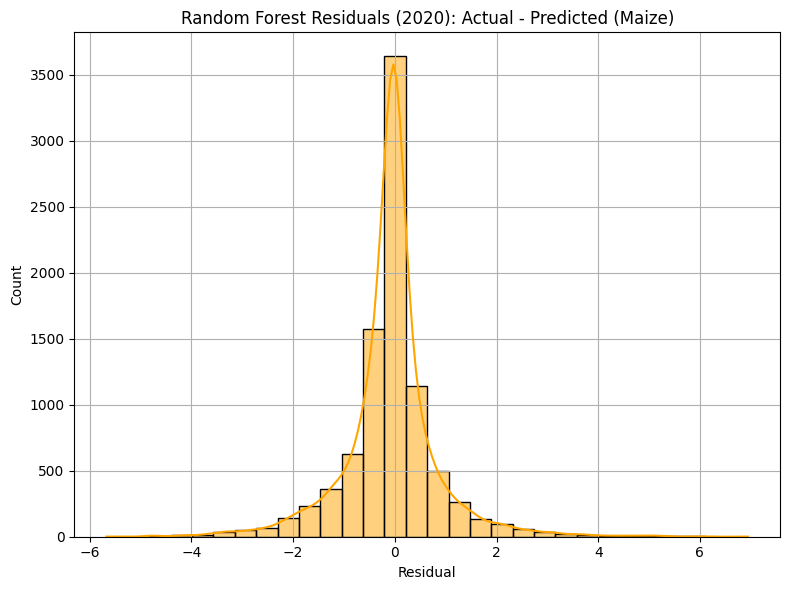

In [18]:
# Residuals (Actual - Predicted)
residuals = y_val - y_val_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='orange')
plt.title("Random Forest Residuals (2020): Actual - Predicted (Maize)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Load test data
maize_test = load_data("maize", "test")

In [21]:
maize_test = load_data("maize", "test")

tasmax_agg_test = aggregate_daily_data(maize_test['tasmax'])
tasmax_agg_test.columns = [f'tasmax_{col}' for col in tasmax_agg_test.columns]

tasmin_agg_test = aggregate_daily_data(maize_test['tasmin'])
tasmin_agg_test.columns = [f'tasmin_{col}' for col in tasmin_agg_test.columns]

pr_agg_test = aggregate_daily_data(maize_test['pr'])
pr_agg_test.columns = [f'pr_{col}' for col in pr_agg_test.columns]

rsds_agg_test = aggregate_daily_data(maize_test['rsds'])
rsds_agg_test.columns = [f'rsds_{col}' for col in rsds_agg_test.columns]

features_test = pd.concat([tasmax_agg_test, tasmin_agg_test, pr_agg_test, rsds_agg_test, maize_test['soil_co2']], axis=1)

numeric_features_test = features_test.select_dtypes(include=[np.number])

numeric_features_test = numeric_features_test.dropna()

features_scaled_test = scaler_maize.transform(numeric_features_test)
test_ids = numeric_features_test.index

In [23]:
rf_predictions = rf_model.predict(features_scaled_test)
rf_results = pd.DataFrame({
    "ID": test_ids,
    "Predicted_Yield": rf_predictions
})
rf_results.head()

,ID,Predicted_Yield
0,349719,5.76270
1,349720,5.36780
2,349721,4.50366
3,349722,1.70354
4,349723,1.87135


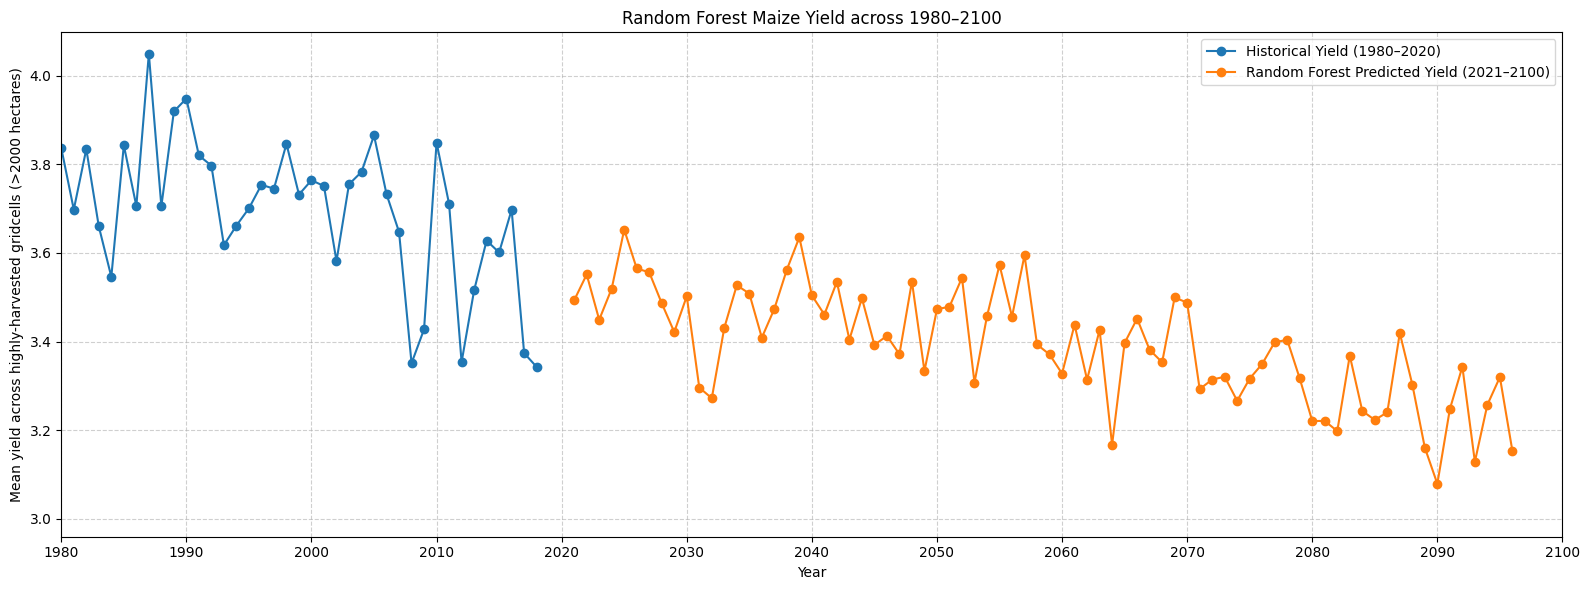

In [24]:
# Step 0: Year decoder function
def decode_year(encoded_year):
    return encoded_year - 381 + 1980

# Step 1: Random Forest predictions (2021–2100), with decoded years
rf_years_decoded = decode_year(maize_test['tasmax'].loc[numeric_features_test.index, 'year']).astype(int)

rf_pred_df = pd.DataFrame({
    "Year": rf_years_decoded,
    "Yield": rf_predictions
}, index=numeric_features_test.index)

rf_future = rf_pred_df[(rf_pred_df["Year"] >= 2021) & (rf_pred_df["Year"] <= 2100)]
rf_future_avg = rf_future.groupby("Year", as_index=False)["Yield"].mean().rename(columns={"Yield": "Yield_pred"})

# Step 2: Historical yield (1980–2020), reuse val_mask and y_train/y_val from earlier RF setup
encoded_years = maize_train["tasmax"]["year"]

# Decode training and validation years
train_years = decode_year(encoded_years[~val_mask].astype(int))
val_years = decode_year(encoded_years[val_mask].astype(int))

historical_years_all = pd.concat([train_years.reset_index(drop=True), val_years.reset_index(drop=True)])
historical_yields_all = np.concatenate([y_train, y_val])

historical_df = pd.DataFrame({
    "Year": historical_years_all,
    "Yield_hist": historical_yields_all
})
historical_avg = historical_df.groupby("Year", as_index=False)["Yield_hist"].mean()

# Step 3: Merge into full 1980–2100 DataFrame
all_years = pd.DataFrame({"Year": range(1980, 2101)})
historical_avg["Year"] = historical_avg["Year"].astype(int)
rf_future_avg["Year"] = rf_future_avg["Year"].astype(int)

plot_df = all_years.merge(historical_avg, on="Year", how="left")
plot_df = plot_df.merge(rf_future_avg, on="Year", how="left")

# Step 4: Plot Random Forest line (same style as XGBoost version)
plt.figure(figsize=(16, 6))
plt.plot(plot_df["Year"][plot_df["Yield_hist"].notna()],
         plot_df["Yield_hist"].dropna(),
         marker="o", color="tab:blue", label="Historical Yield (1980–2020)")

plt.plot(plot_df["Year"][plot_df["Yield_pred"].notna()],
         plot_df["Yield_pred"].dropna(),
         marker="o", color="tab:orange", label="Random Forest Predicted Yield (2021–2100)")

plt.xlabel("Year")
plt.ylabel("Mean yield across highly-harvested gridcells (>2000 hectares)")
plt.title("Random Forest Maize Yield across 1980–2100")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(1980, 2100)
plt.xticks(range(1980, 2101, 10))
plt.ylim(2.96)
plt.legend()
plt.tight_layout()
plt.show()


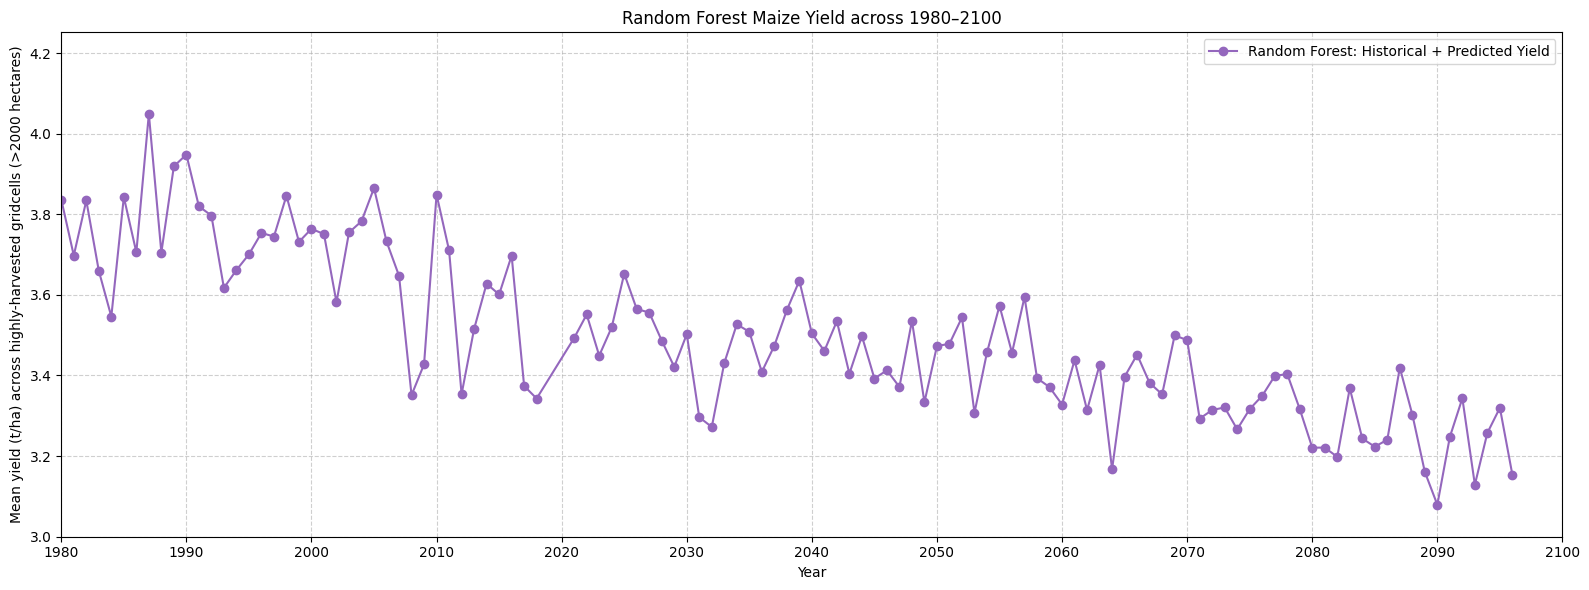

In [25]:
# Combine historical and predicted yields into one continuous series
combined_yield = pd.concat([
    plot_df.set_index("Year")["Yield_hist"].dropna(),
    plot_df.set_index("Year")["Yield_pred"].dropna()
])

# Plot the full timeline
plt.figure(figsize=(16, 6))
plt.plot(combined_yield.index, combined_yield.values, marker="o", color="tab:purple", label="Random Forest: Historical + Predicted Yield")
plt.xlabel("Year")
plt.ylabel("Mean yield (t/ha) across highly-harvested gridcells (>2000 hectares)")
plt.title("Random Forest Maize Yield across 1980–2100")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(1980, 2100)
plt.ylim(3.0, combined_yield.max() * 1.05)  # Start y-axis at 3.0
plt.xticks(range(1980, 2101, 10))
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_31/3358589718.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=importances[top_idx], y=features[top_idx], ci=None)


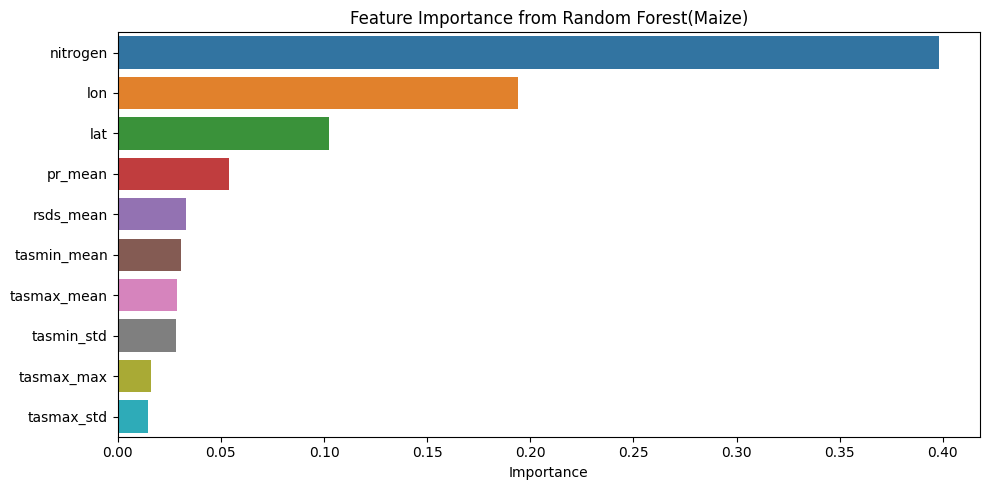

In [29]:
# Feature importance from XGBoost
importances = rf_model.feature_importances_
features = numeric_features_maize.columns
sorted_idx = np.argsort(importances)[::-1]  # Descending order
top_idx = sorted_idx[:10]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[top_idx], y=features[top_idx], ci=None)
plt.title("Feature Importance from Random Forest(Maize)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [33]:
importances = rf_model.feature_importances_
features = numeric_features_maize.columns

# Create a DataFrame of features and their importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by importance descending
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display top N (optional)
importance_df.head(20)

,Feature,Importance
0,nitrogen,0.398079
1,lon,0.193801
2,lat,0.102404
3,pr_mean,0.053933
4,rsds_mean,0.032931
5,tasmin_mean,0.030464
6,tasmax_mean,0.028493
7,tasmin_std,0.028429
8,tasmax_max,0.016101
9,tasmax_std,0.014698


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


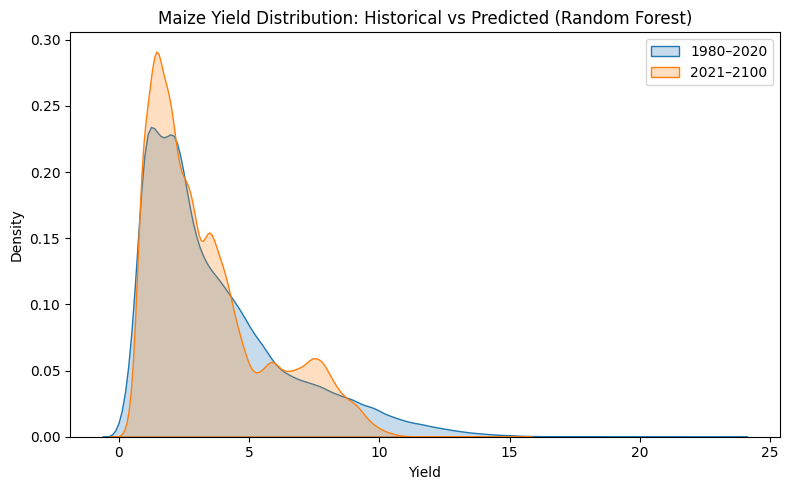

In [30]:
# Prepare historical and predicted yield DataFrames (same structure as XGBoost version)
historical_rf_df = historical_df[["Year", "Yield_hist"]].rename(columns={"Yield_hist": "Yield"})
historical_rf_df = historical_rf_df[(historical_rf_df["Year"] >= 1980) & (historical_rf_df["Year"] <= 2020)]

future_rf_df = rf_pred_df[rf_pred_df["Year"] >= 2021]

# KDE plot for yield distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(data=historical_rf_df, x="Yield", label="1980–2020", fill=True)
sns.kdeplot(data=future_rf_df, x="Yield", label="2021–2100", fill=True)
plt.title("Maize Yield Distribution: Historical vs Predicted (Random Forest)")
plt.xlabel("Yield")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()